## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-indoor' 
TRANSFORM = 'wavelet-horizontal'
CHANNEL = 'green'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
green_horizontal_wavelet_indoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/indoor/wavelet/horizontal/green'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 1604,
 3: 6416,
 4: 25664,
 5: 102656,
 6: 410624,
 7: 1642496,
 8: 6569984,
 9: 26279936}

Running 12760 CDFs


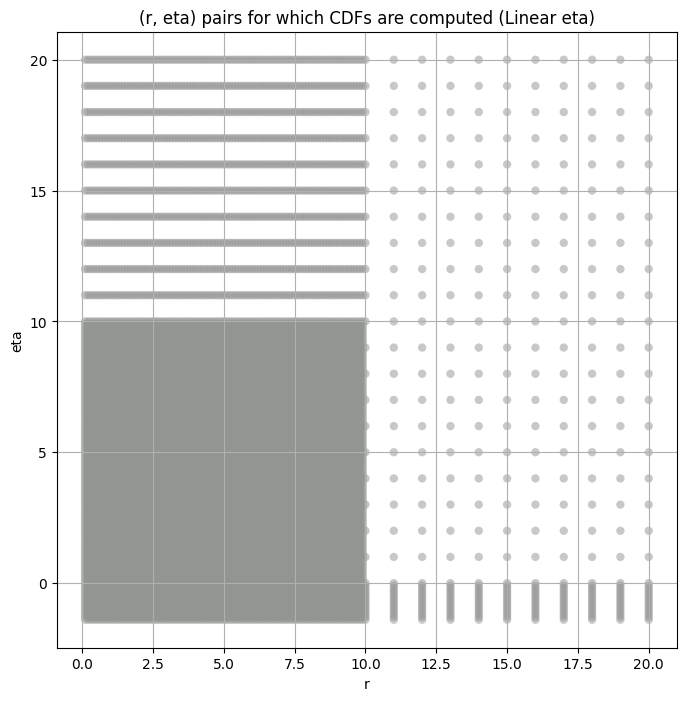

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      5985.273000  5503.828000  6472.603000  -0.432959   -0.596103   
3      1380.426300  1307.072600  1454.920800   0.765229    0.531162   
4       306.009600   289.181550   323.314100   2.672753    2.176988   
5        57.695510    53.856068    61.713856   5.086591    3.921928   
6        10.505858     9.662853    11.417748   8.542816    6.626442   
7         1.867550     1.683422     2.075731  14.345919   10.306082   
8         0.354478     0.310975     0.410297  26.125399   15.367449   
9         0.076985     0.065887     0.092856  41.475616   20.096338   

       kurt_upper  total_samples  
layer                             
2       -0.248452           1604  
3        1.023549           6416  
4        3.469344          25664  
5        7.117451         102656  
6       14.380970         410624  
7       27.592405        1642496  
8       82.588196        6569984  
9      141.567830       26279936

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      5985.273000    5985.272949     5173.758789     4582.172363   
3      1380.426300    1380.426270     1273.051392     1199.506104   
4       306.009600     306.009613      293.201538      284.171814   
5        57.695510      57.695511       56.360439       55.555801   
6        10.505858      10.505858       10.199805       10.002604   
7         1.867550       1.867550        1.788990        1.740643   
8         0.354478       0.354478        0.333242        0.321283   
9         0.076985       0.076985        0.070818        0.067652   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         4099.155273      3683.977539      2981.909424      2423.308350   
3         1138.372314      1085.103882       992.284119       912.760803   
4          276.357697       269.359985       256.993134       246.471924   
5           54.849316        54.204437        53.030422        51.989021   
6            9.831825         9.677542         9.401210         9.155173   
7            1.699607         1.663109         1.599510         1.544394   
8            0.311301         0.302519         0.287389         0.274497   
9            0.065076         0.062852         0.059096         0.055965   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          1960.415771      1564.527466      1227.058105       503.127380  
3           843.671387       783.087524       728.303650       591.951782  
4           237.053711       228.628967       220.874985       201.129364  
5            51.022984        50.123627        49.287189        47.053566  
6             8.930481         8.722859         8.529585         8.019477  
7             1.495323         1.450761         1.409854         1.303909  
8             0.263209         0.253120         0.244002         0.220984  
9             0.053264         0.050886         0.048764         0.043495

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.10414500929027276 5985.273


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.11401776535131303 5173.759


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.1253297202928193 4582.1724


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.13613176355952028 4099.1553


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.14726255894584306 3683.9775


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.17254797921758191 2981.9094


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.19759774718586454 2423.3083


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.22288043652580602 1960.4158


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.2486857544237816 1564.5275


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.2746725980770143 1227.0581


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.36601718211477374 503.12738
Number of samples: 1604, Without approximation : 1604


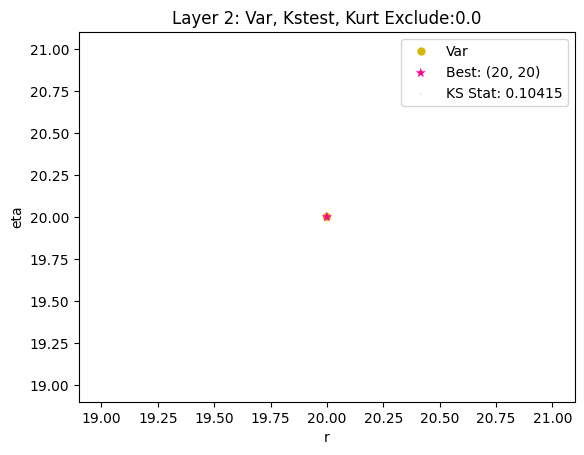

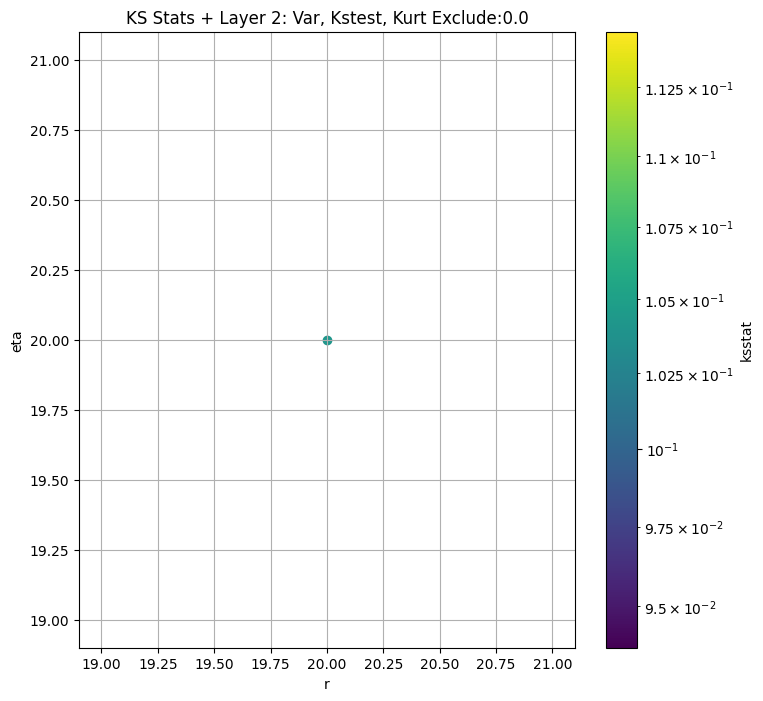

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.05879062249221867 1380.4263


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.05885033758970126 1273.0514


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.058822793071753365 1199.5061


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.05892428086229462 1138.3723


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.059039783722618366 1085.1039


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.05956112695934024 992.2841


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.06041413537862628 912.7608


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.06327631416193258 843.6714


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.07150180811822471 783.0875


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.08014438820103831 728.30365


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.10511019435351132 591.9518
Number of samples: 6416, Without approximation : 6416


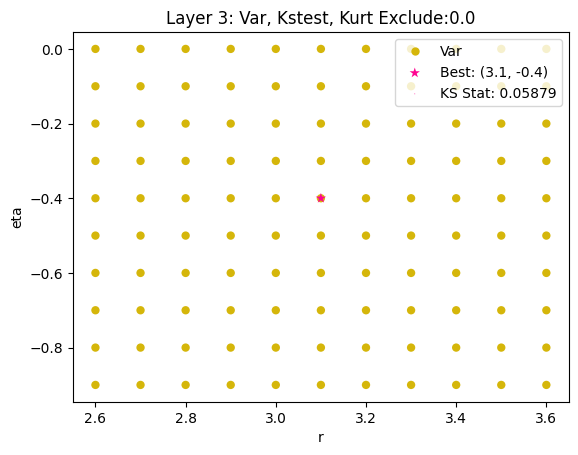

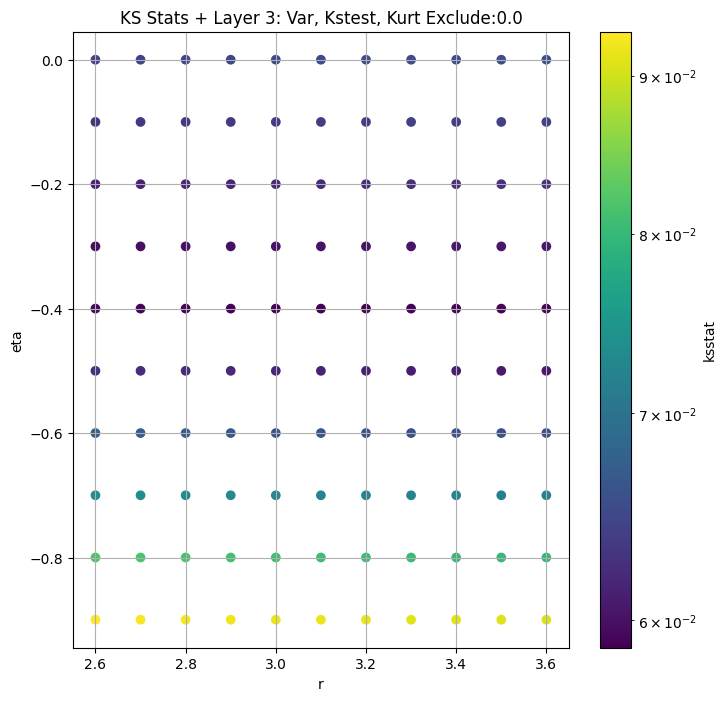

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.04380111705860584 306.0096


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.043803514792115916 293.20154


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.043804568348407014 284.1718


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.04380051838812532 276.3577


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.043799777415680474 269.36


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.043808888181383066 256.99313


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.043802786934462934 246.47192


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.04380057125011927 237.05371


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.04380118919289672 228.62897


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.043800651480490393 220.87498


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.04423457161999467 201.12936
Number of samples: 25664, Without approximation : 25664


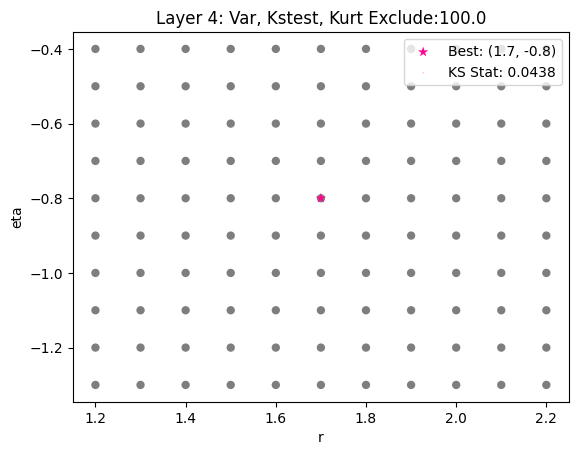

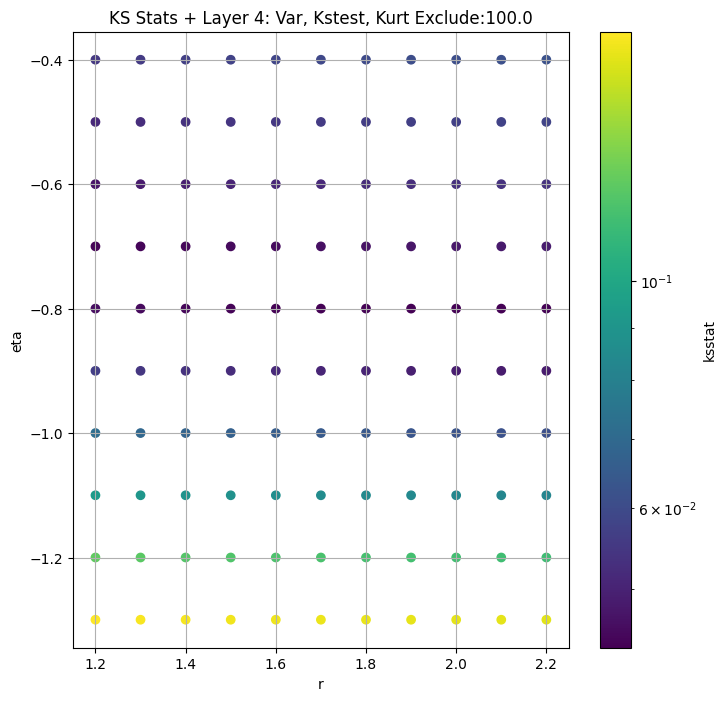

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.03400734169971953 57.69551


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.033974705359060386 56.36044


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.034070546488550846 55.5558


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.033813196172273796 54.849316


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.03389127295246569 54.204437


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.03395472800357213 53.030422


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.03388410314395501 51.98902


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.033786271665824985 51.022984


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.033887994379218356 50.123627


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.03379767486355362 49.28719


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.03378258690739072 47.053566
Number of samples: 100000, Without approximation : 102656


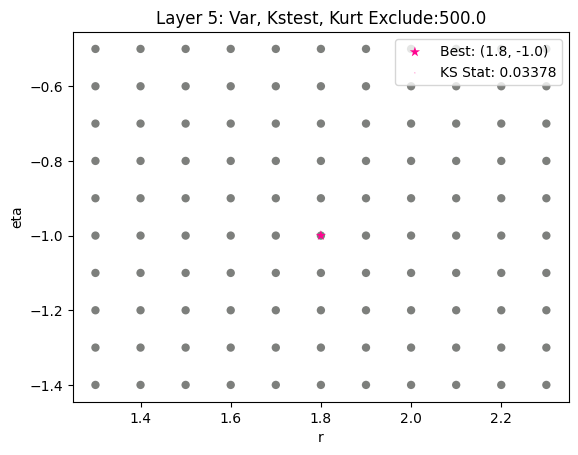

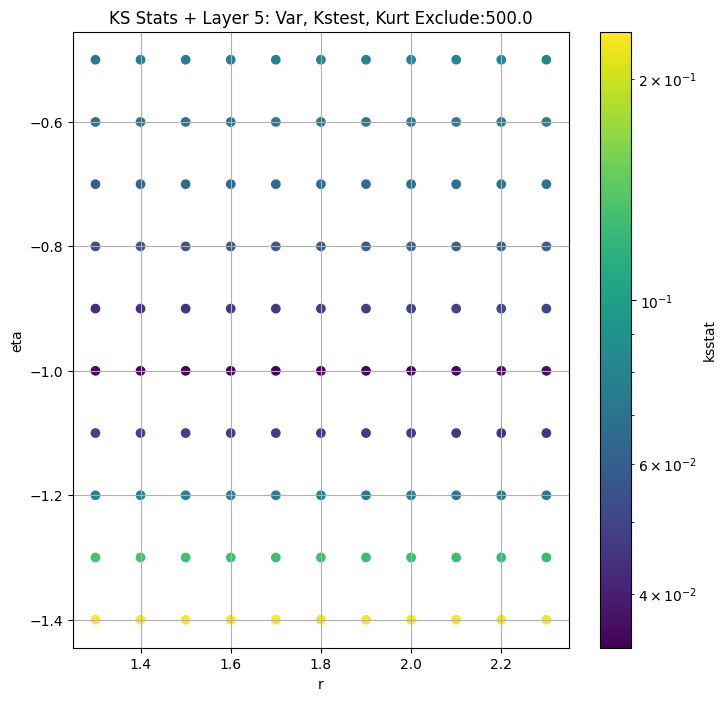

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.031331457227856685 10.505858


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.031193725815456264 10.199805


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.03110187100393358 10.0026045


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.031020243552680682 9.831825


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.03074407889619646 9.677542


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.030805265796934156 9.40121


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.03067612105755163 9.155173


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.030579224492996326 8.930481


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.030770377127403492 8.722859


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.031079542449679476 8.529585


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.03082179495974169 8.019477
Number of samples: 100000, Without approximation : 410624


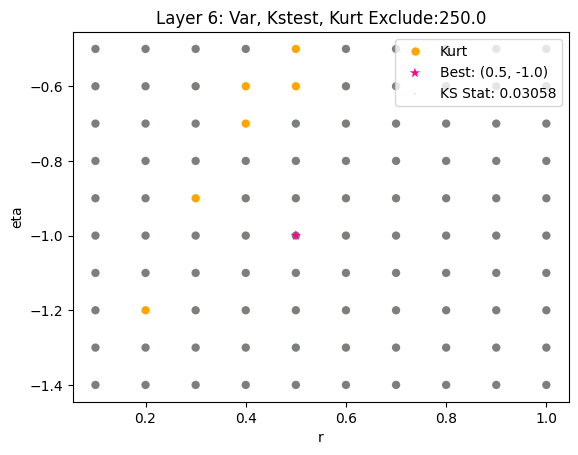

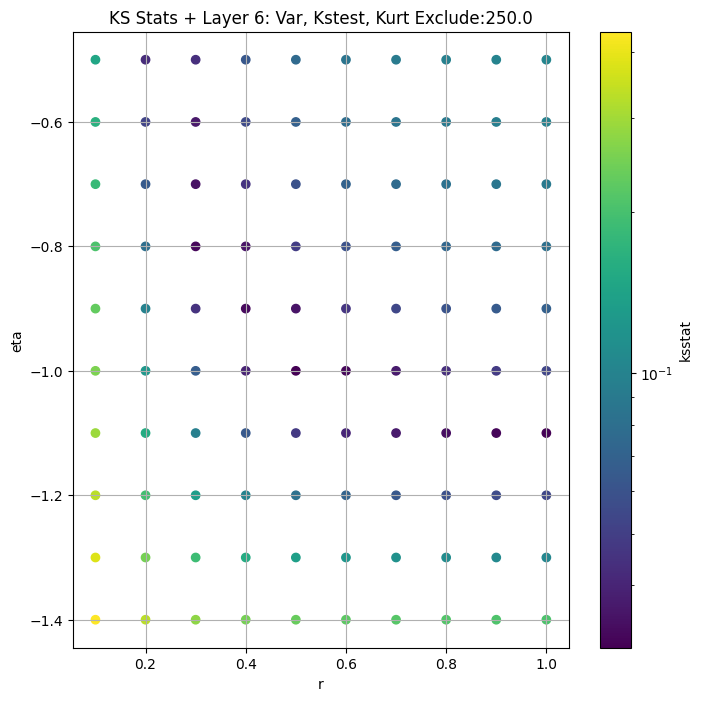

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.030676963099408816 1.8675501


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.03045973912131547 1.7889904


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.02896718732317749 1.7406431


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.029577650122326382 1.6996069


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.03022124650007152 1.6631088


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.028837311086241935 1.5995102


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.029420922478453293 1.5443935


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.02872062349463886 1.4953231


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.02891812312007669 1.4507611


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.028419978512758237 1.4098537


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.02854814971637315 1.3039094
Number of samples: 100000, Without approximation : 1642496


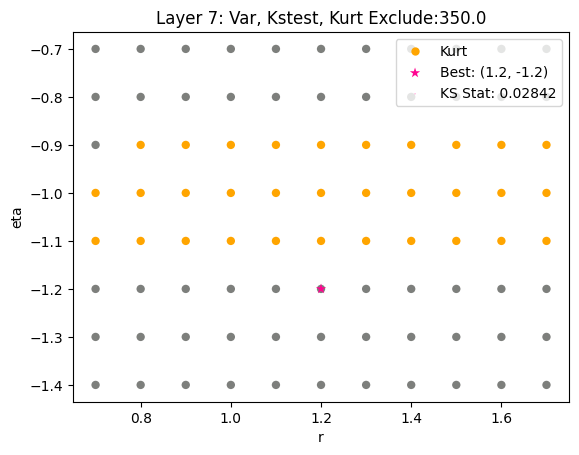

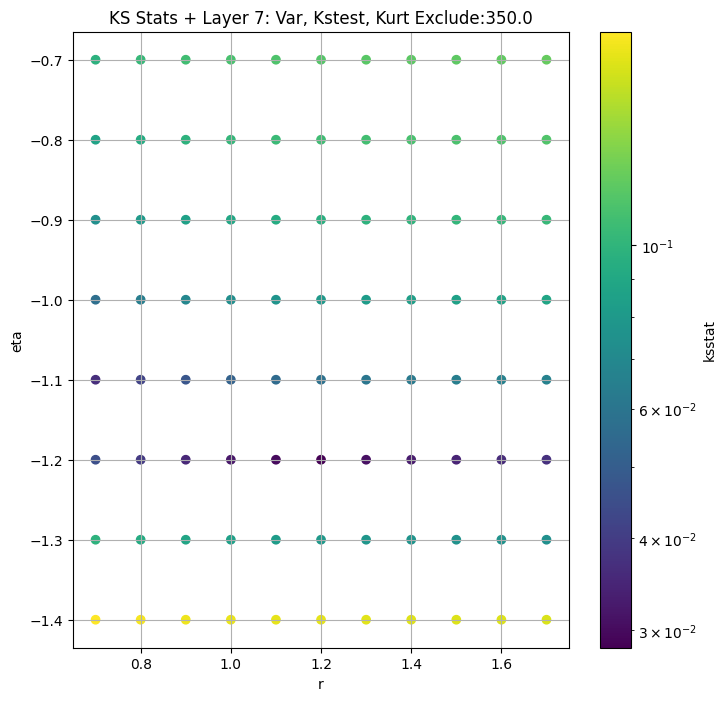

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.0173244204316787 0.35447773


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.016708964034742257 0.33324224


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.016149684873919212 0.32128292


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.01566259205783771 0.31130147


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.01521743239116391 0.30251876


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.014447296640617946 0.2873888


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.01652457301364696 0.27449745


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.015990178366636243 0.2632085


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.01533689971304436 0.25312027


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.014752715709448139 0.24400157


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.015203981054005 0.22098394
Number of samples: 100000, Without approximation : 6569984


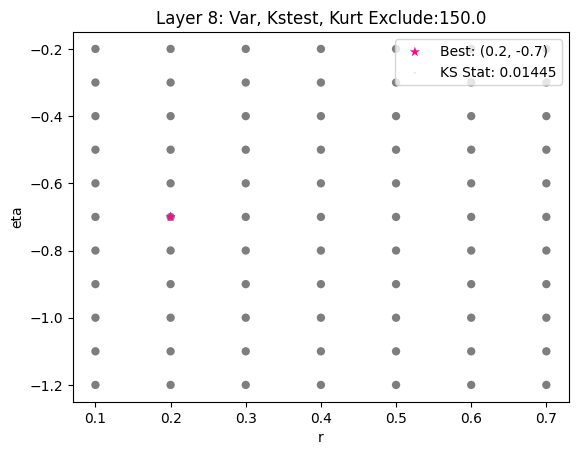

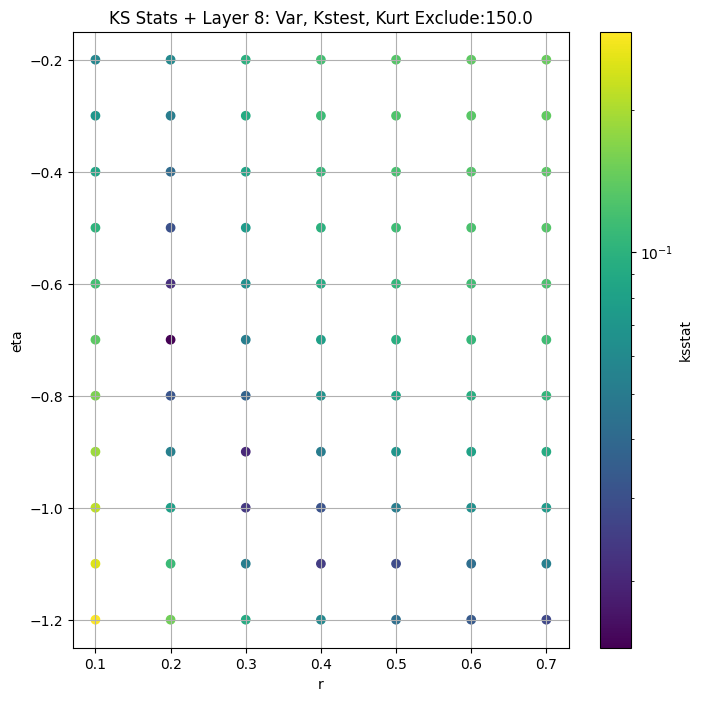

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.010297334987097506 0.07698516


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.01398903278194491 0.070818


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.012445497520843285 0.067651965


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.013600647916523156 0.06507649


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.014301600994791386 0.06285225


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.011273182312771357 0.05909576


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.010087179905097332 0.055965453


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.011355409418902895 0.053264294


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.01324026720111704 0.05088638


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.01519879036652394 0.048763976


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.01164873377877973 0.04349451
Number of samples: 100000, Without approximation : 26279936


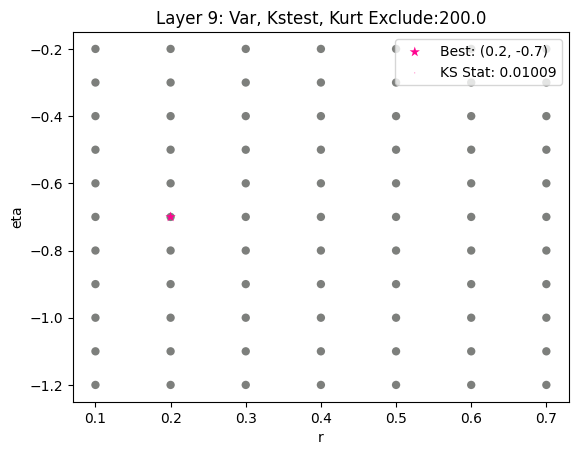

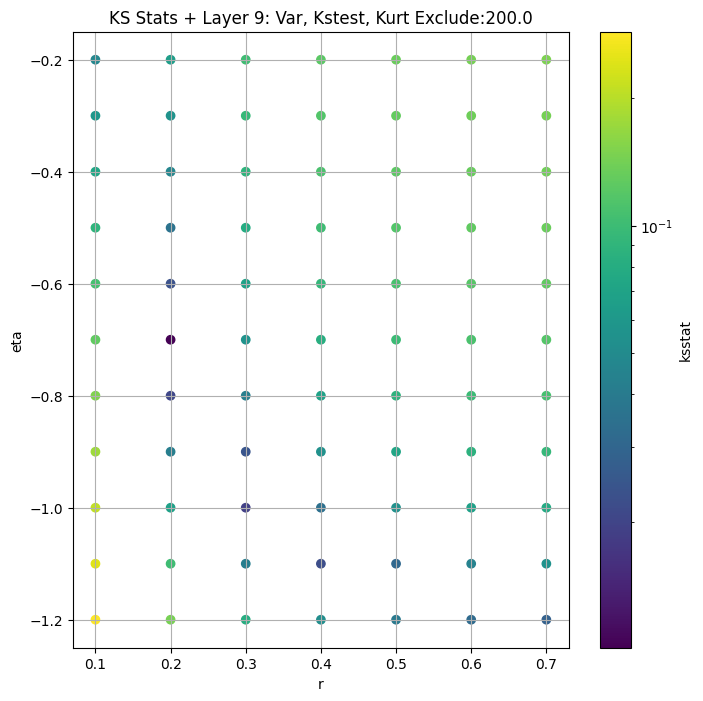

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      5985.273000  5503.828000  6472.603000  -0.432959   -0.596103   
3      1380.426300  1307.072600  1454.920800   0.765229    0.531162   
4       306.009600   289.181550   323.314100   2.672753    2.176988   
5        57.695510    53.856068    61.713856   5.086591    3.921928   
6        10.505858     9.662853    11.417748   8.542816    6.626442   
7         1.867550     1.683422     2.075731  14.345919   10.306082   
8         0.354478     0.310975     0.410297  26.125399   15.367449   
9         0.076985     0.065887     0.092856  41.475616   20.096338   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       -0.248452           1604             0.104145       20.0         20.0   
3        1.023549           6416             0.058791        3.1         -0.4   
4        3.469344          25664             0.043800        1.7         -0.8   
5        7.117451         102656             0.033783        1.8         -1.0   
6       14.380970         410624             0.030579        0.5         -1.0   
7       27.592405        1642496             0.028420        1.2         -1.2   
8       82.588196        6569984             0.014447        0.2         -0.7   
9      141.567830       26279936             0.010087        0.2         -0.7   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        6113.499679                     0.0         5985.273000   
3        2594.914013                     0.0         1380.426300   
4         580.034464                   100.0          269.360000   
5         135.225551                   500.0           47.053566   
6           4.465240                   250.0            8.930481   
7           5.334087                   350.0            1.409854   
8           0.000043                   150.0            0.287389   
9           0.000008                   200.0            0.055965   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.033804  
3                     0.016929  
4                     0.008471  
5                     0.004237  
6                     0.002119  
7                     0.001060  
8                     0.000530  
9                     0.000265

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.14726255894584306, var: 3683.9775390625


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.13613176355952028, var: 4099.1552734375


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.1253297202928193, var: 4582.17236328125


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.11401776535131303, var: 5173.7587890625


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.10414500929027276, var: 5985.27294921875
Number of samples: 1604, Without approximation : 1604


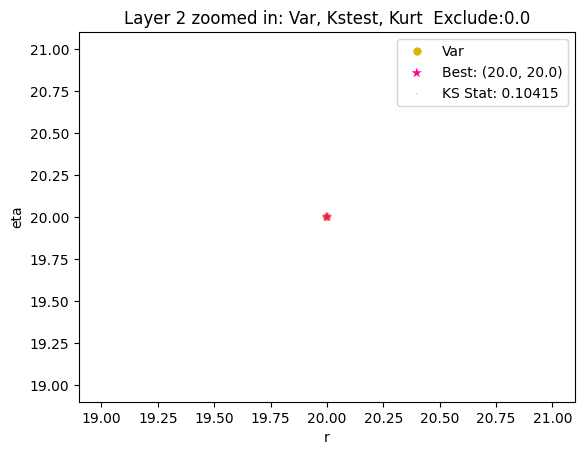

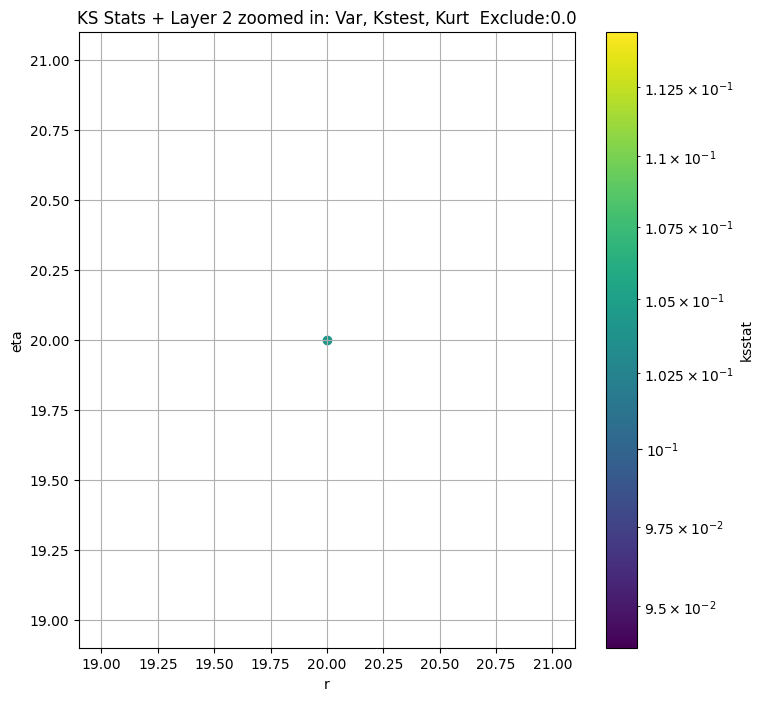

Layer 3


  0%|          | 0/162 [00:00<?, ?it/s]

Finding Minimum after computing 162 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.05915355469263345, var: 1085.1038818359375


  0%|          | 0/162 [00:00<?, ?it/s]

Finding Minimum after computing 162 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.059014826057881165, var: 1138.372314453125


  0%|          | 0/162 [00:00<?, ?it/s]

Finding Minimum after computing 162 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.05890864711326821, var: 1199.506103515625


  0%|          | 0/162 [00:00<?, ?it/s]

Finding Minimum after computing 162 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.05885033758970126, var: 1273.0513916015625


  0%|          | 0/162 [00:00<?, ?it/s]

Finding Minimum after computing 162 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.05879062249221867, var: 1380.42626953125
Number of samples: 6416, Without approximation : 6416


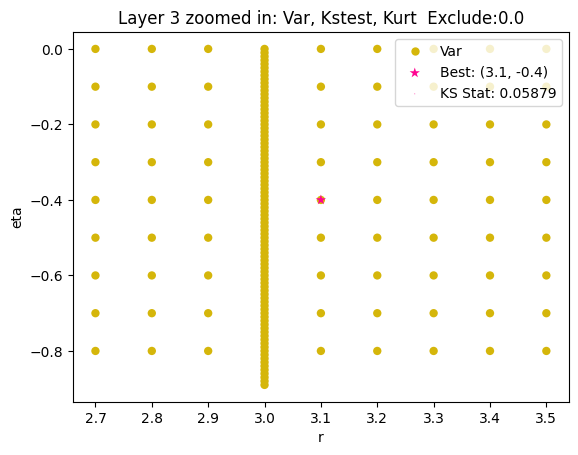

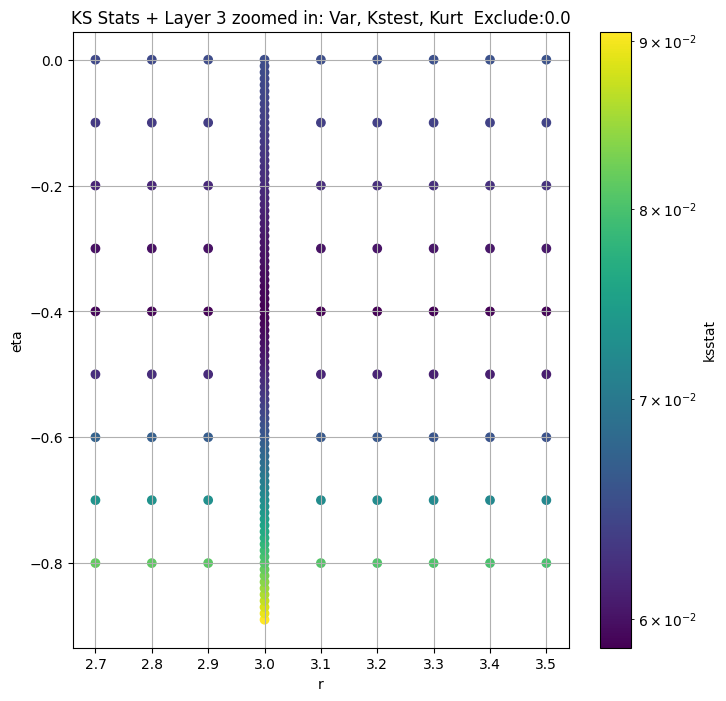

Layer 4


  0%|          | 0/1449 [00:00<?, ?it/s]

Finding Minimum after computing 1449 CDFs
layer 4, 100.0 + 100 = 200, ksstat: 0.043812855585802946, var: 246.471923828125


  0%|          | 0/1449 [00:00<?, ?it/s]

Finding Minimum after computing 1449 CDFs
layer 4, 100.0 + 75 = 175, ksstat: 0.04380076523009524, var: 251.57699584960938


  0%|          | 0/1449 [00:00<?, ?it/s]

Finding Minimum after computing 1449 CDFs
layer 4, 100.0 + 50 = 150, ksstat: 0.043797456544852675, var: 256.9931335449219


  0%|          | 0/1449 [00:00<?, ?it/s]

Finding Minimum after computing 1449 CDFs
layer 4, 100.0 + 25 = 125, ksstat: 0.04379257168716538, var: 262.894775390625


  0%|          | 0/1449 [00:00<?, ?it/s]

Finding Minimum after computing 1449 CDFs
layer 4, 100.0 + 0 = 100, ksstat: 0.04379580985164877, var: 269.3599853515625


  0%|          | 0/1449 [00:00<?, ?it/s]

Finding Minimum after computing 1449 CDFs
layer 4, 100.0 + -25 = 75, ksstat: 0.0437905668364903, var: 276.3576965332031


  0%|          | 0/1449 [00:00<?, ?it/s]

Finding Minimum after computing 1449 CDFs
layer 4, 100.0 + -50 = 50, ksstat: 0.04377432313850066, var: 284.17181396484375


  0%|          | 0/1449 [00:00<?, ?it/s]

Finding Minimum after computing 1449 CDFs
layer 4, 100.0 + -75 = 25, ksstat: 0.043772090671236774, var: 293.2015380859375


  0%|          | 0/1449 [00:00<?, ?it/s]

Finding Minimum after computing 1449 CDFs
layer 4, 100.0 + -100 = 0, ksstat: 0.043762785666767445, var: 306.0096130371094
Number of samples: 25664, Without approximation : 25664


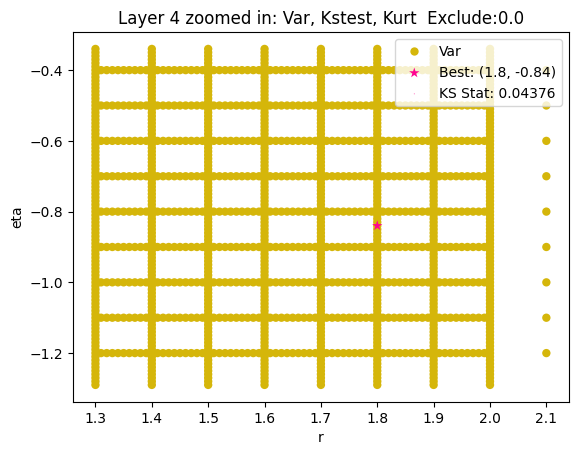

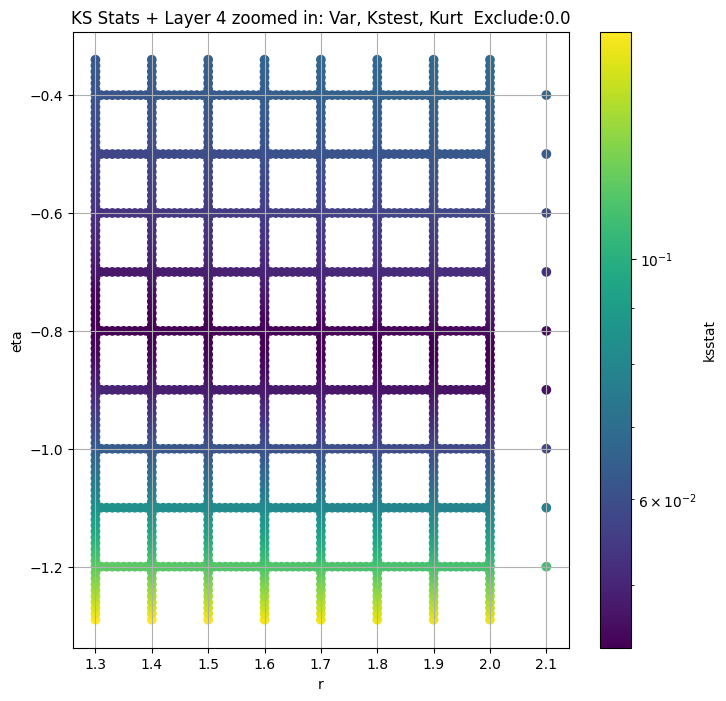

Layer 5


  0%|          | 0/1259 [00:00<?, ?it/s]

Finding Minimum after computing 1259 CDFs
layer 5, 500.0 + 100 = 600, ksstat: 0.03373819822229157, var: 45.73591232299805


  0%|          | 0/1259 [00:00<?, ?it/s]

Finding Minimum after computing 1259 CDFs
layer 5, 500.0 + 75 = 575, ksstat: 0.03371612716717054, var: 46.05429458618164


  0%|          | 0/1259 [00:00<?, ?it/s]

Finding Minimum after computing 1259 CDFs
layer 5, 500.0 + 50 = 550, ksstat: 0.03371607376828961, var: 46.3807373046875


  0%|          | 0/1259 [00:00<?, ?it/s]

Finding Minimum after computing 1259 CDFs
layer 5, 500.0 + 25 = 525, ksstat: 0.03371573388576299, var: 46.713623046875


  0%|          | 0/1259 [00:00<?, ?it/s]

Finding Minimum after computing 1259 CDFs
layer 5, 500.0 + 0 = 500, ksstat: 0.03371595044611614, var: 47.053565979003906


  0%|          | 0/1259 [00:00<?, ?it/s]

Finding Minimum after computing 1259 CDFs
layer 5, 500.0 + -25 = 475, ksstat: 0.03371619198727549, var: 47.40158462524414


  0%|          | 0/1259 [00:00<?, ?it/s]

Finding Minimum after computing 1259 CDFs
layer 5, 500.0 + -50 = 450, ksstat: 0.033715015716823726, var: 47.75856018066406


  0%|          | 0/1259 [00:00<?, ?it/s]

Finding Minimum after computing 1259 CDFs
layer 5, 500.0 + -75 = 425, ksstat: 0.033721070850267154, var: 48.124019622802734


  0%|          | 0/1259 [00:00<?, ?it/s]

Finding Minimum after computing 1259 CDFs
layer 5, 500.0 + -100 = 400, ksstat: 0.033731806104794926, var: 48.499595642089844
Number of samples: 100000, Without approximation : 102656


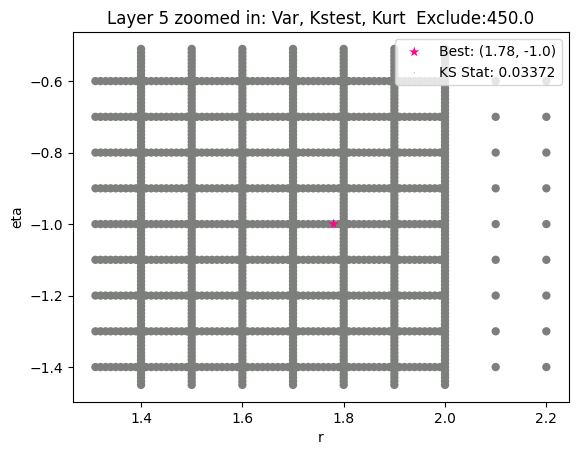

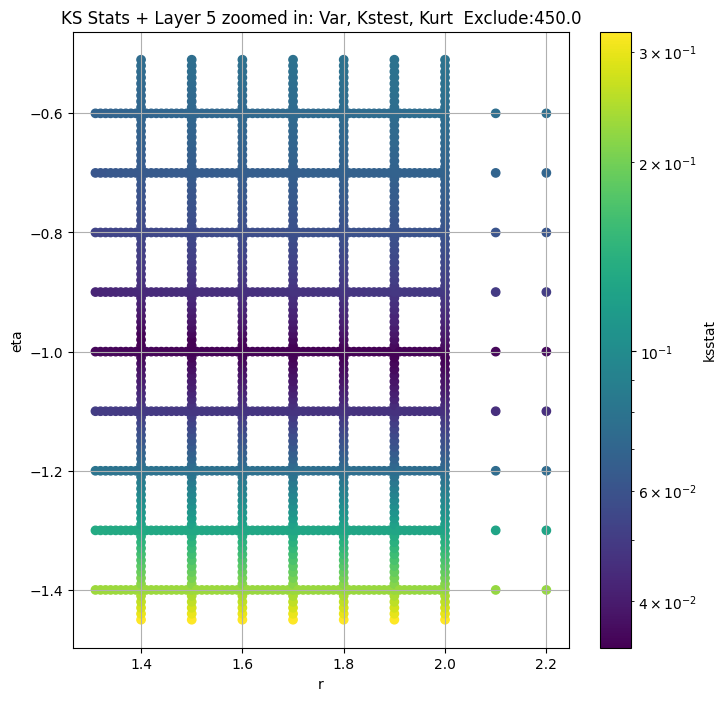

Layer 6


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 250.0 + 100 = 350, ksstat: 0.02982835655002175, var: 8.529584884643555


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 250.0 + 75 = 325, ksstat: 0.029882261450049907, var: 8.62451457977295


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 250.0 + 50 = 300, ksstat: 0.029983779970770952, var: 8.722859382629395


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 250.0 + 25 = 275, ksstat: 0.03004023555265878, var: 8.824722290039062


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 250.0 + 0 = 250, ksstat: 0.030068860136556852, var: 8.93048095703125


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 250.0 + -25 = 225, ksstat: 0.029956859154721738, var: 9.040348052978516


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 250.0 + -50 = 200, ksstat: 0.030018704263539864, var: 9.155173301696777


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 250.0 + -75 = 175, ksstat: 0.030018486274746903, var: 9.275124549865723


  0%|          | 0/1656 [00:00<?, ?it/s]

Finding Minimum after computing 1656 CDFs
layer 6, 250.0 + -100 = 150, ksstat: 0.029832029395313597, var: 9.401209831237793
Number of samples: 100000, Without approximation : 410624


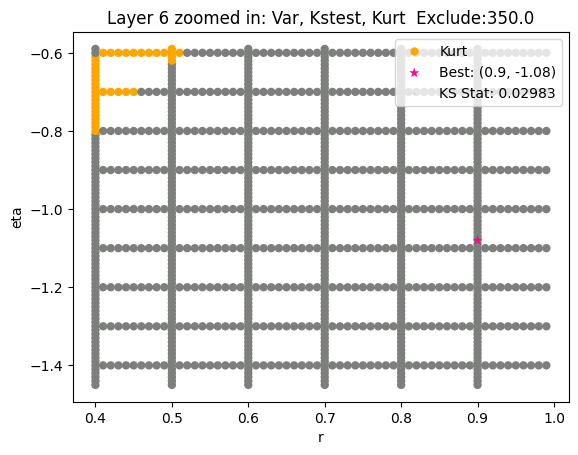

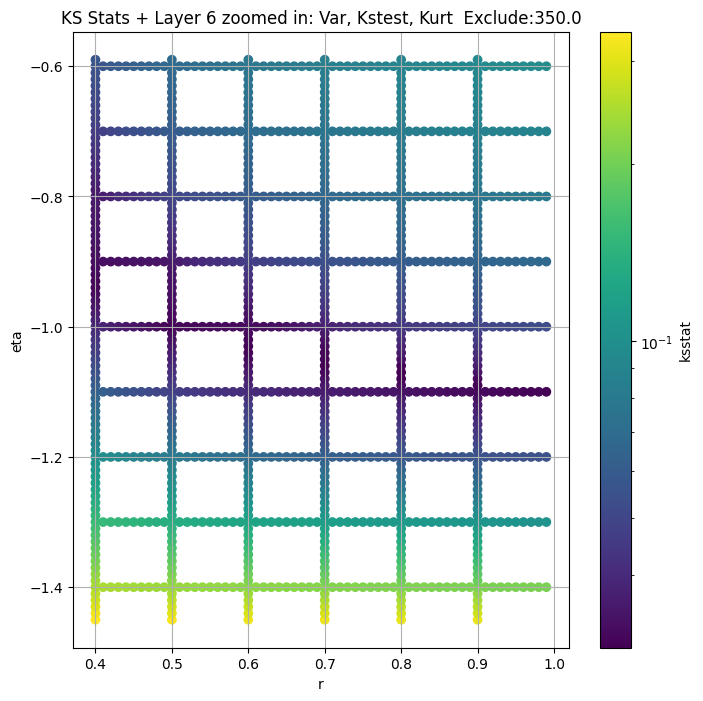

Layer 7


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + 100 = 450, ksstat: 0.026351372905277115, var: 1.3368923664093018


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + 75 = 425, ksstat: 0.026446738685160343, var: 1.3541781902313232


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + 50 = 400, ksstat: 0.026965121047518636, var: 1.3720639944076538


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + 25 = 375, ksstat: 0.027676169588771338, var: 1.390602469444275


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + 0 = 350, ksstat: 0.027759559795325073, var: 1.4098536968231201


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + -25 = 325, ksstat: 0.027330484858815396, var: 1.4298938512802124


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + -50 = 300, ksstat: 0.026891543847333832, var: 1.450761079788208


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + -75 = 275, ksstat: 0.026441741083349513, var: 1.4725373983383179


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 350.0 + -100 = 250, ksstat: 0.026958792698589584, var: 1.4953230619430542
Number of samples: 100000, Without approximation : 1642496


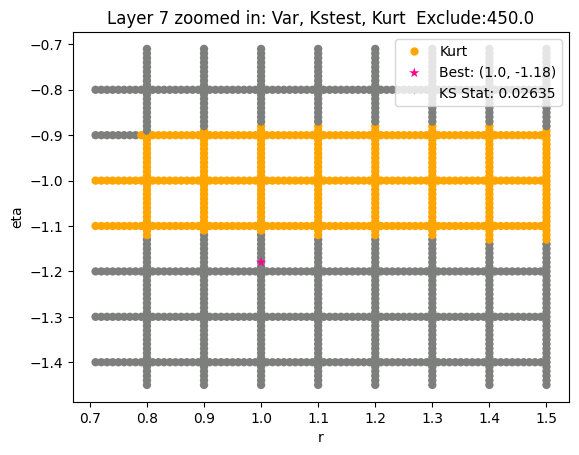

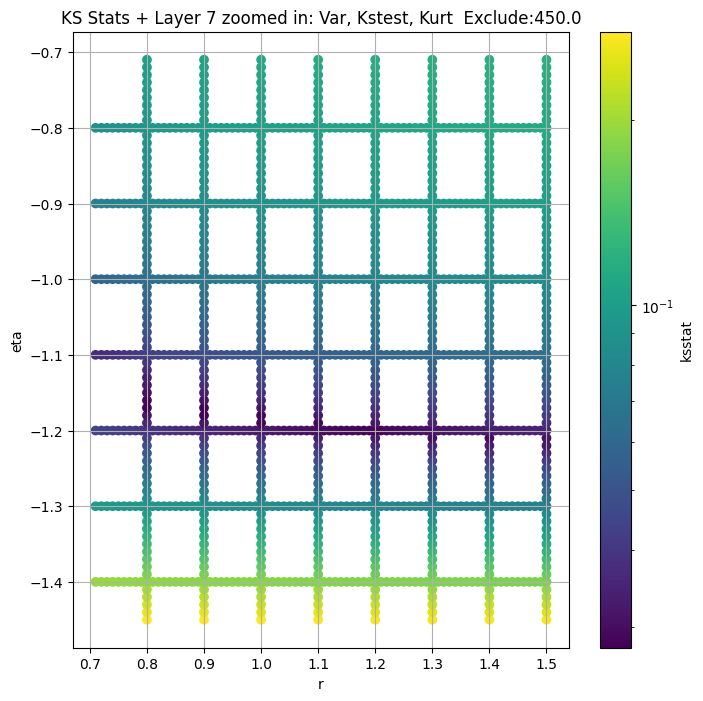

Layer 8


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 150.0 + 100 = 250, ksstat: 0.013007342189213456, var: 0.2632085084915161


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 150.0 + 75 = 225, ksstat: 0.01300404959834417, var: 0.2686813175678253


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 150.0 + 50 = 200, ksstat: 0.013261464497222764, var: 0.27449744939804077


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 150.0 + 25 = 175, ksstat: 0.013155044894614887, var: 0.28071480989456177


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 150.0 + 0 = 150, ksstat: 0.013053529553493204, var: 0.28738880157470703


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 150.0 + -25 = 125, ksstat: 0.013022486728248128, var: 0.29460787773132324


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 150.0 + -50 = 100, ksstat: 0.013041619620776879, var: 0.302518755197525


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 150.0 + -75 = 75, ksstat: 0.013485347321357866, var: 0.31130146980285645


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 8, 150.0 + -100 = 50, ksstat: 0.013643545104744415, var: 0.32128292322158813
Number of samples: 100000, Without approximation : 6569984


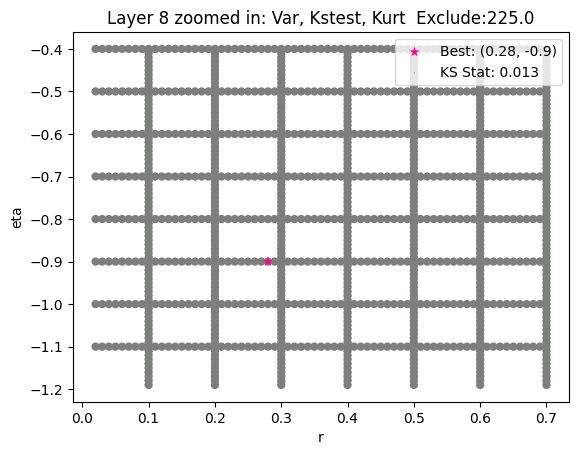

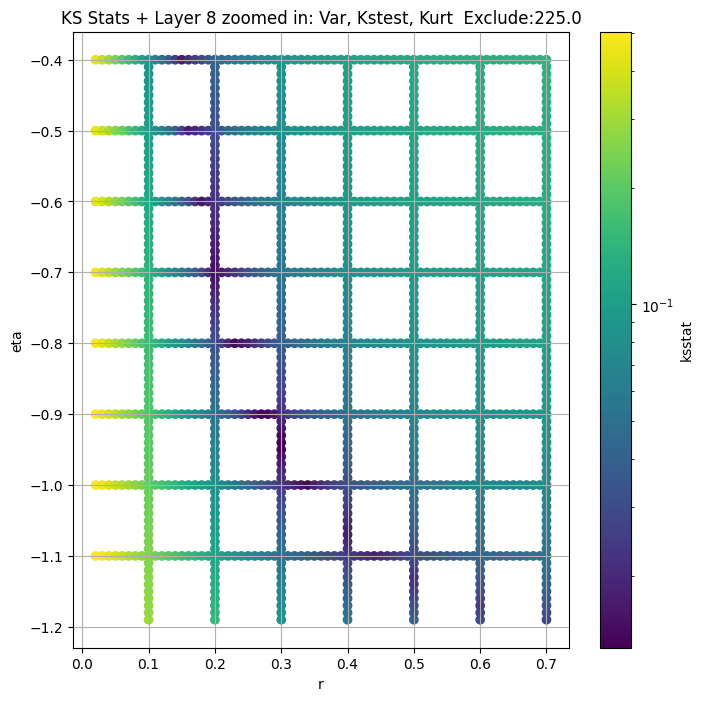

Layer 9


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 200.0 + 100 = 300, ksstat: 0.011029017514622375, var: 0.050886381417512894


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 200.0 + 75 = 275, ksstat: 0.011106274612970424, var: 0.052039455622434616


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 200.0 + 50 = 250, ksstat: 0.0105908284146502, var: 0.05326429381966591


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 200.0 + 25 = 225, ksstat: 0.010050948462301257, var: 0.05456943064928055


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 200.0 + 0 = 200, ksstat: 0.010087179905097332, var: 0.05596545338630676


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 200.0 + -25 = 175, ksstat: 0.009966009556363675, var: 0.05746694654226303


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 200.0 + -50 = 150, ksstat: 0.010091184347003734, var: 0.05909575894474983


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 200.0 + -75 = 125, ksstat: 0.010359488903943115, var: 0.060877725481987


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 9, 200.0 + -100 = 100, ksstat: 0.010133443876410464, var: 0.06285224854946136
Number of samples: 100000, Without approximation : 26279936


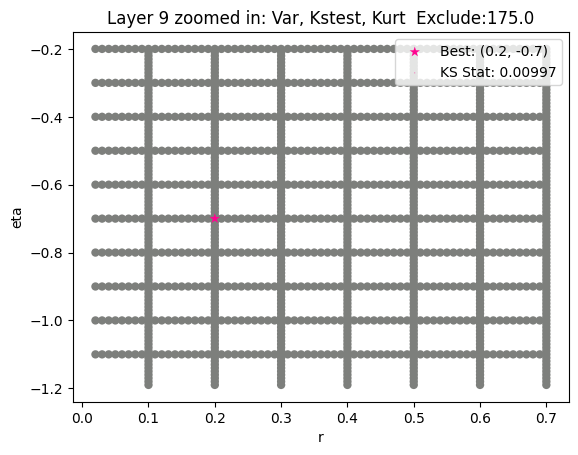

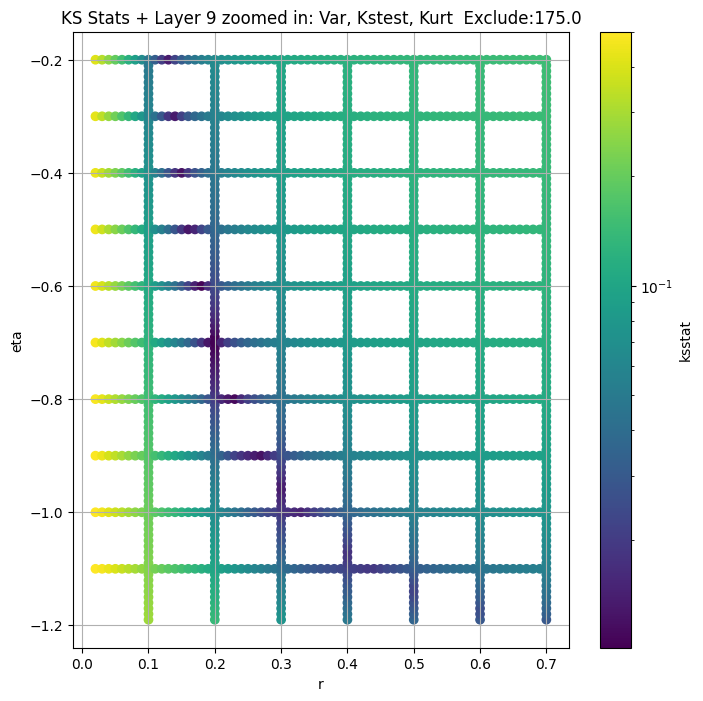

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      5985.273000  5503.828000  6472.603000  -0.432959   -0.596103   
3      1380.426300  1307.072600  1454.920800   0.765229    0.531162   
4       306.009600   289.181550   323.314100   2.672753    2.176988   
5        57.695510    53.856068    61.713856   5.086591    3.921928   
6        10.505858     9.662853    11.417748   8.542816    6.626442   
7         1.867550     1.683422     2.075731  14.345919   10.306082   
8         0.354478     0.310975     0.410297  26.125399   15.367449   
9         0.076985     0.065887     0.092856  41.475616   20.096338   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       -0.248452           1604             0.104145       20.0         20.0   
3        1.023549           6416             0.058791        3.1         -0.4   
4        3.469344          25664             0.043800        1.7         -0.8   
5        7.117451         102656             0.033783        1.8         -1.0   
6       14.380970         410624             0.030579        0.5         -1.0   
7       27.592405        1642496             0.028420        1.2         -1.2   
8       82.588196        6569984             0.014447        0.2         -0.7   
9      141.567830       26279936             0.010087        0.2         -0.7   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        6113.499679                     0.0         5985.273000   
3        2594.914013                     0.0         1380.426300   
4         580.034464                   100.0          306.009613   
5         135.225551                   500.0           47.758560   
6           4.465240                   250.0            8.529585   
7           5.334087                   350.0            1.336892   
8           0.000043                   150.0            0.268681   
9           0.000008                   200.0            0.057467   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.033804          0.104145   20.00     20.00   
3                     0.016929          0.058791    3.10     -0.40   
4                     0.008471          0.043763    1.80     -0.84   
5                     0.004237          0.033715    1.78     -1.00   
6                     0.002119          0.029828    0.90     -1.08   
7                     0.001060          0.026351    1.00     -1.18   
8                     0.000530          0.013004    0.28     -0.90   
9                     0.000265          0.009966    0.20     -0.70   

        best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                 
2      6113.499679                  0.0          168  
3      2594.914013                  0.0          505  
4       706.171891                  0.0         1012  
5       136.768061                450.0         1604  
6        18.162995                350.0         2029  
7         4.177789                450.0         2706  
8         0.003868                225.0        10827  
9         0.000009                175.0        19248

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

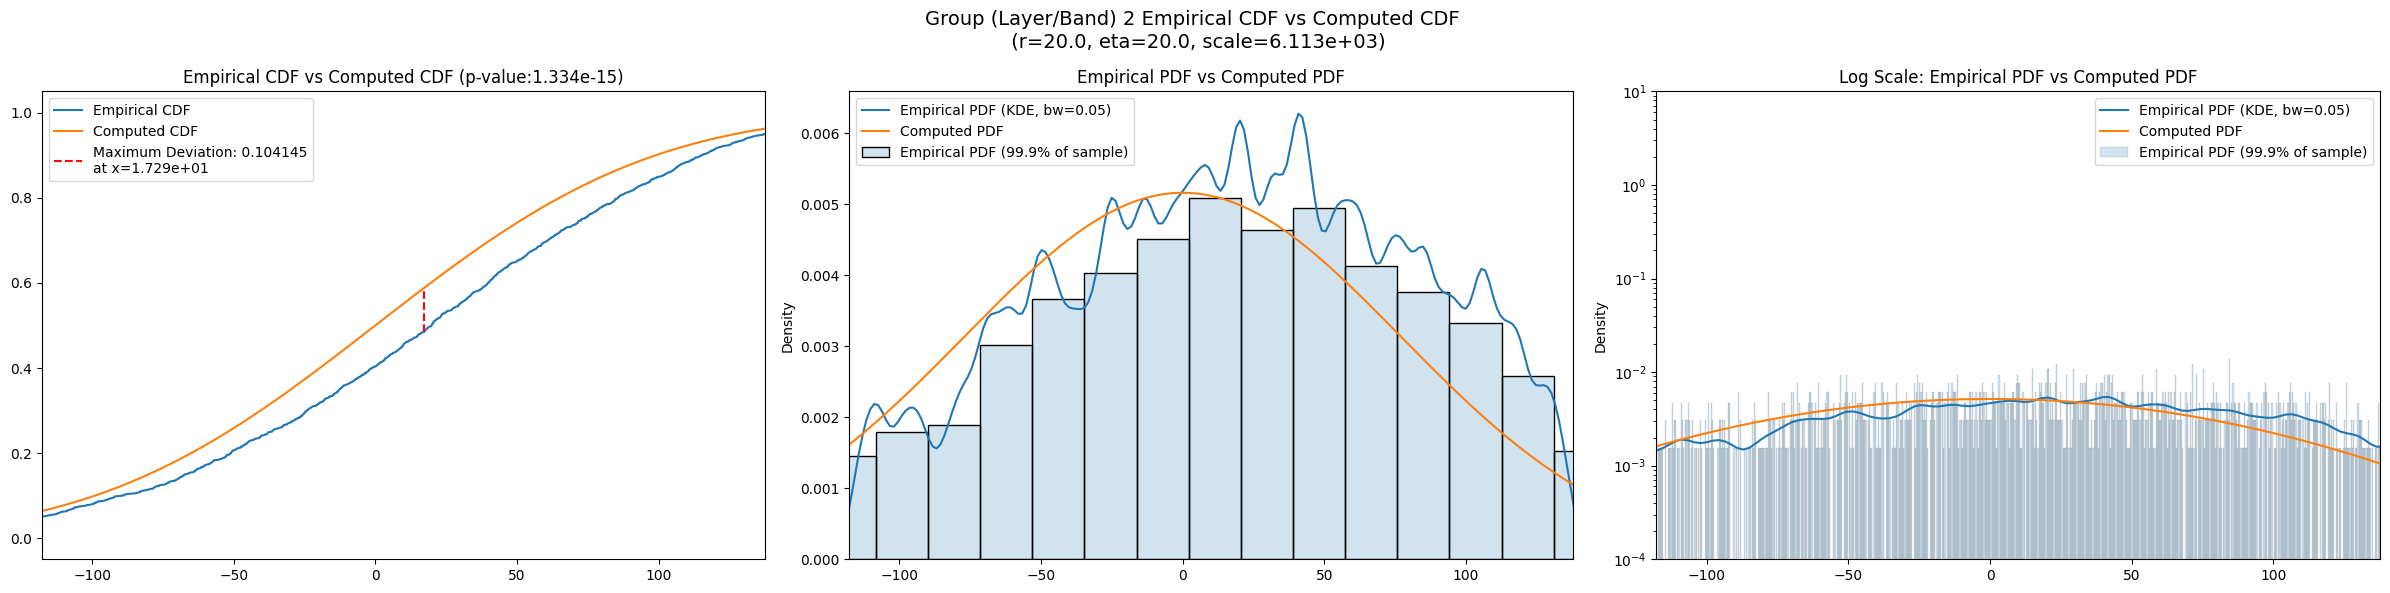

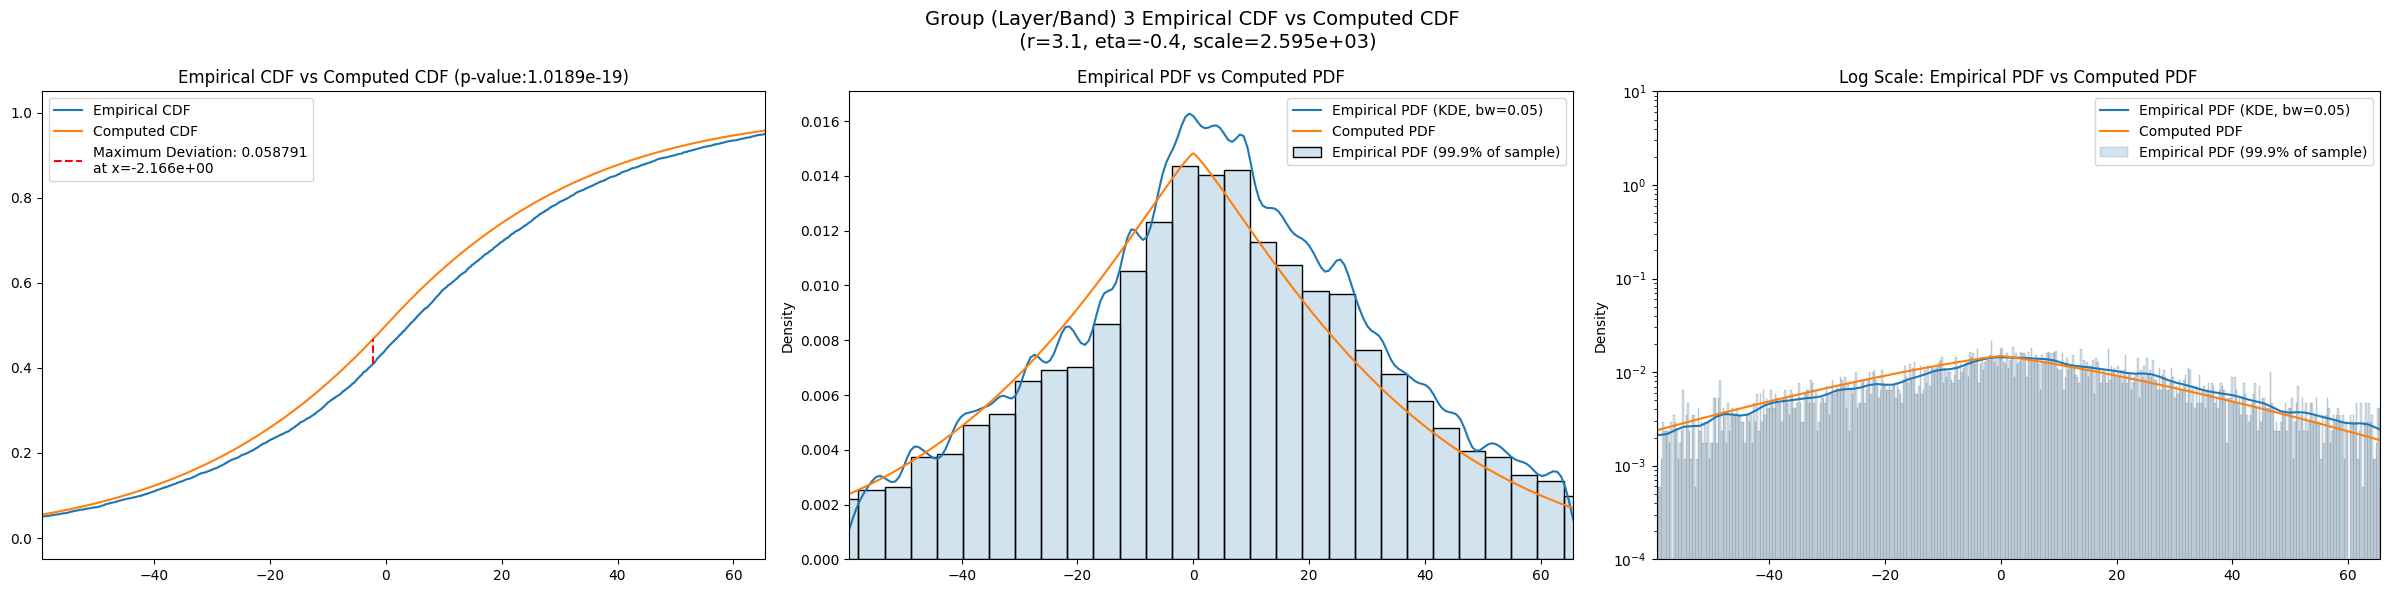

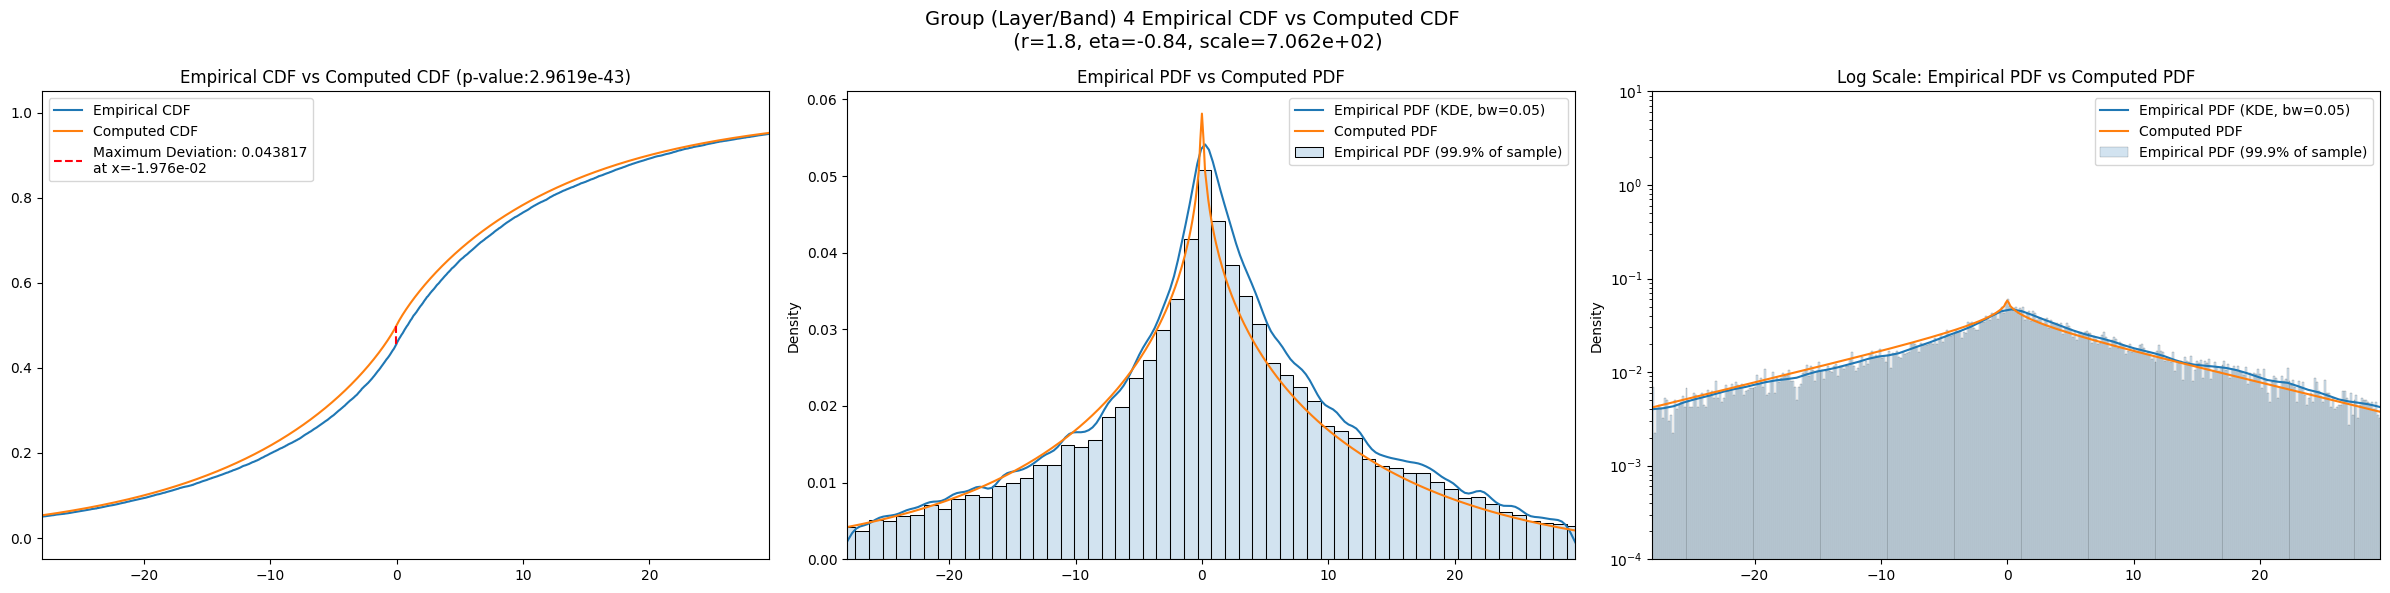

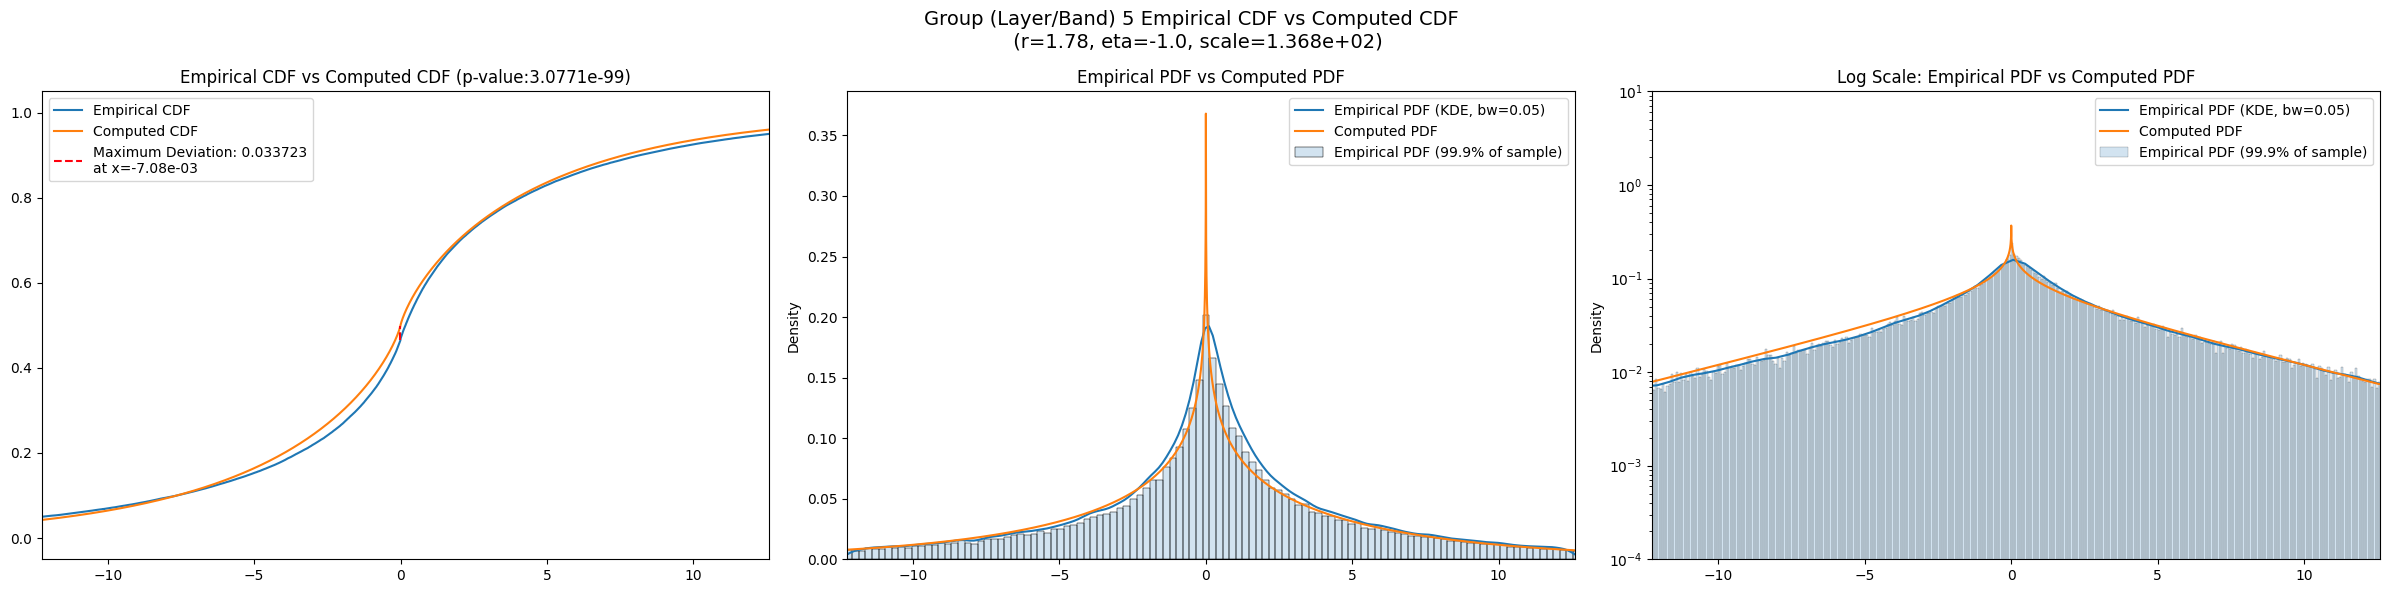

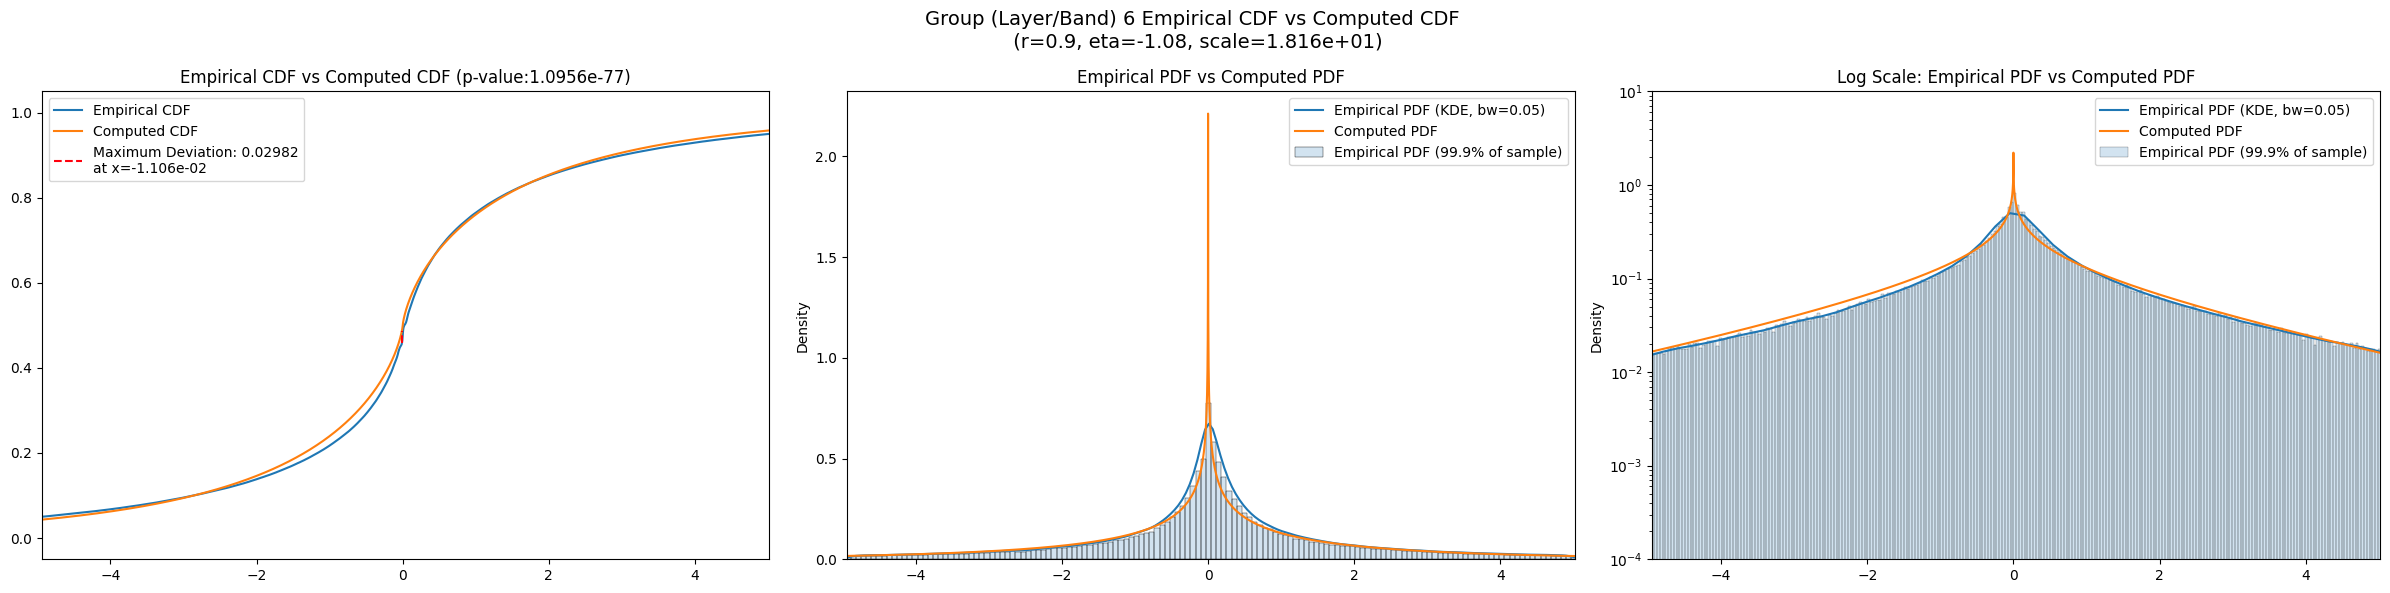

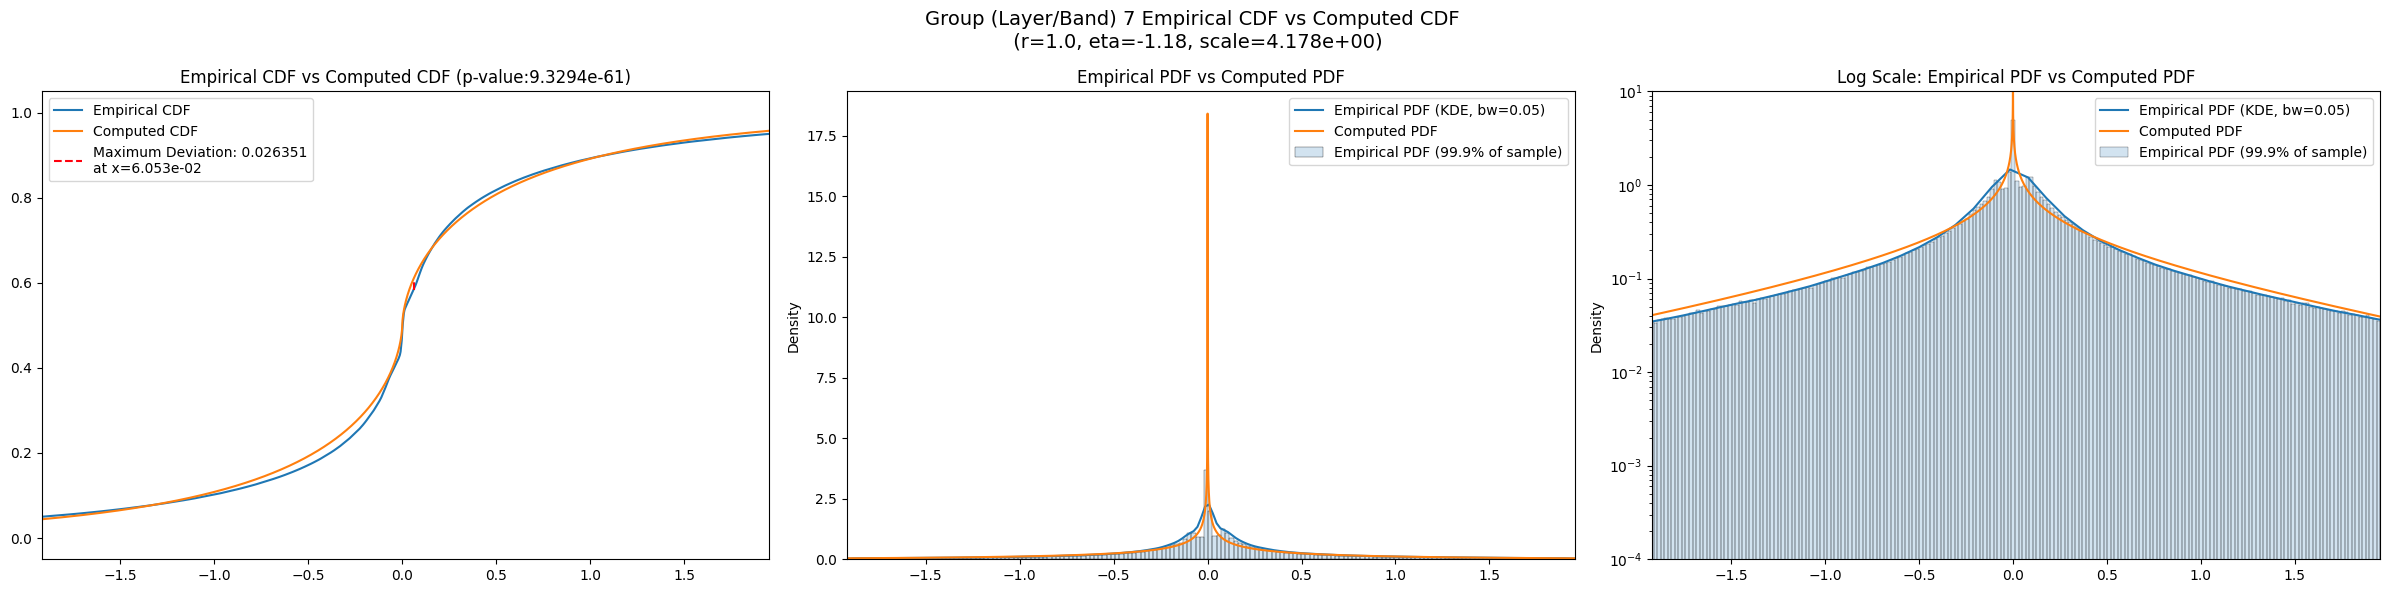

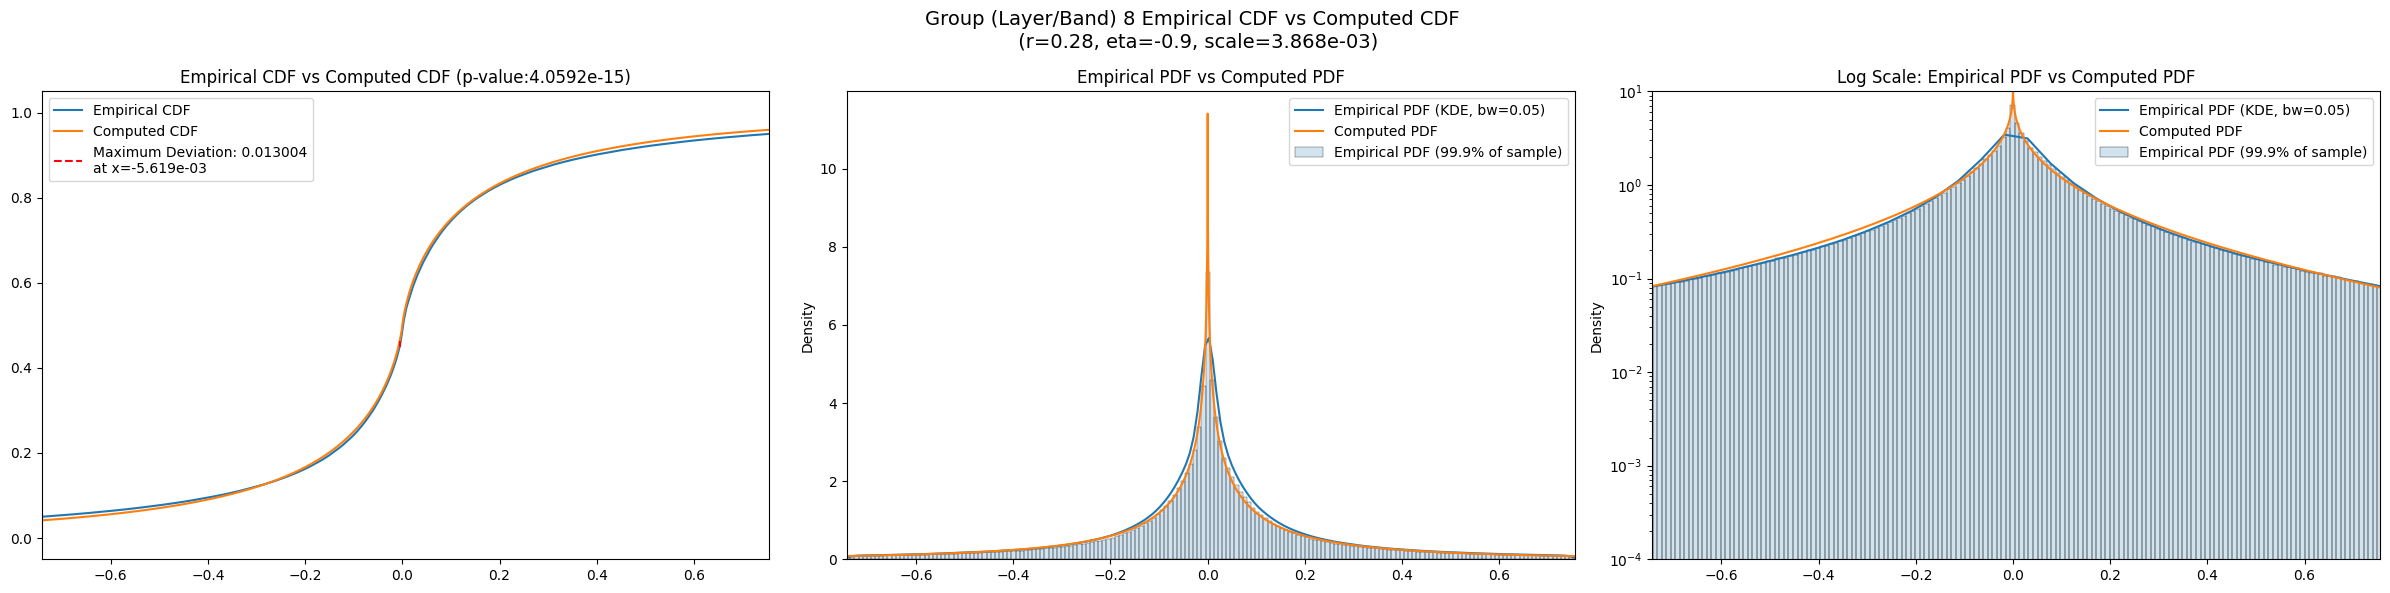

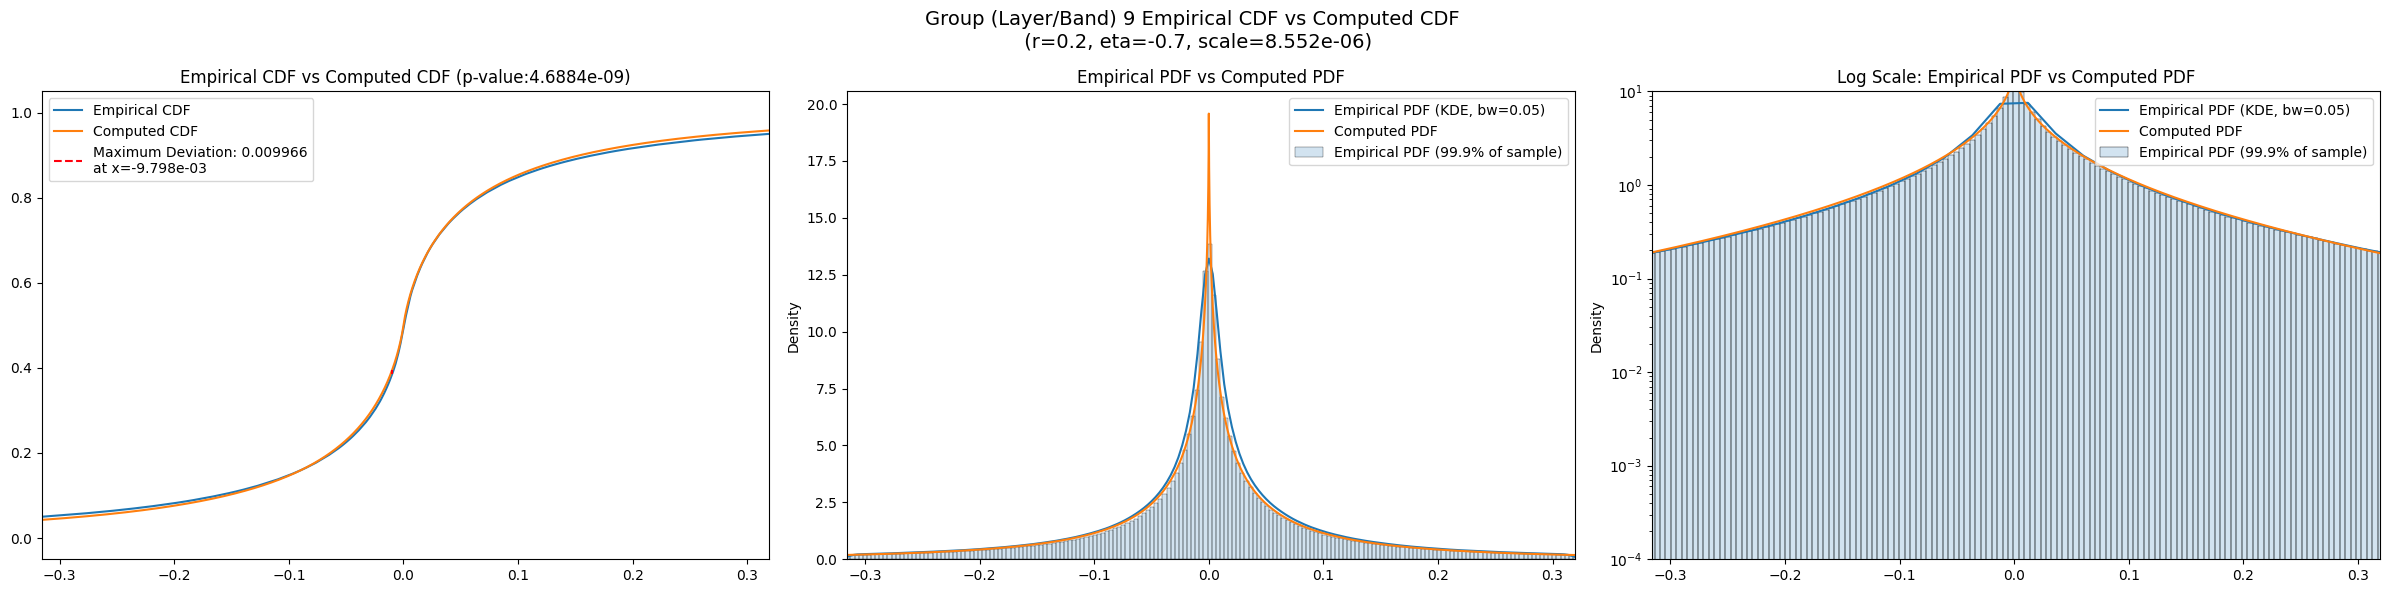

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      5985.273000  5503.828000  6472.603000  -0.432959   -0.596103   
3      1380.426300  1307.072600  1454.920800   0.765229    0.531162   
4       306.009600   289.181550   323.314100   2.672753    2.176988   
5        57.695510    53.856068    61.713856   5.086591    3.921928   
6        10.505858     9.662853    11.417748   8.542816    6.626442   
7         1.867550     1.683422     2.075731  14.345919   10.306082   
8         0.354478     0.310975     0.410297  26.125399   15.367449   
9         0.076985     0.065887     0.092856  41.475616   20.096338   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       -0.248452           1604             0.104145       20.0         20.0   
3        1.023549           6416             0.058791        3.1         -0.4   
4        3.469344          25664             0.043800        1.7         -0.8   
5        7.117451         102656             0.033783        1.8         -1.0   
6       14.380970         410624             0.030579        0.5         -1.0   
7       27.592405        1642496             0.028420        1.2         -1.2   
8       82.588196        6569984             0.014447        0.2         -0.7   
9      141.567830       26279936             0.010087        0.2         -0.7   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       86.407400              0.097457          1.032620e-13   
3      ...       29.343500              0.060981          3.492400e-21   
4      ...       12.028400              0.061110          9.331200e-84   
5      ...        4.374000              0.069890          0.000000e+00   
6      ...        1.477360              0.079648          0.000000e+00   
7      ...        0.508738              0.083647          0.000000e+00   
8      ...        0.195317              0.078939          0.000000e+00   
9      ...        0.081744              0.079469          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          93.789500             0.100088         1.931840e-14  76.556200   
3          33.078000             0.058711         1.149650e-19  24.520700   
4          10.414300             0.045049         1.070450e-45   8.831770   
5           3.713680             0.046246        3.154520e-191   3.029000   
6           1.261340             0.054375         0.000000e+00   1.000320   
7           0.440793             0.057775         0.000000e+00   0.344967   
8           0.170060             0.053657         0.000000e+00   0.130195   
9           0.071150             0.054036         0.000000e+00   0.054905   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.097458   1.032170e-13          1.334026e-15  
3           0.059233   5.209460e-20          1.018894e-19  
4           0.049439   5.921230e-55          3.787302e-43  
5           0.051489  5.679640e-237         8.143666e-102  
6           0.057333   0.000000e+00                   NaN  
7           0.058146   0.000000e+00          0.000000e+00  
8           0.053891   0.000000e+00          0.000000e+00  
9           0.053975   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.104145                 0.033804          0.104145   
3                 0.058791                 0.016929          0.058791   
4                 0.043800                 0.008471          0.043763   
5                 0.033783                 0.004237          0.033715   
6                 0.030579                 0.002119          0.029828   
7                 0.028420                 0.001060          0.026351   
8                 0.014447                 0.000530          0.013004   
9                 0.010087                 0.000265          0.009966   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.097457             0.100088       0.097458  
3                  0.060981             0.058711       0.059233  
4                  0.061110             0.045049       0.049439  
5                  0.069890             0.046246       0.051489  
6                  0.079648             0.054375       0.057333  
7                  0.083647             0.057775       0.058146  
8                  0.078939             0.053657       0.053891  
9                  0.079469             0.054036       0.053975

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta   best_scale  \
layer                                                                        
2             5985.273000          0.104145   20.00     20.00  6113.499679   
3             1380.426300          0.058791    3.10     -0.40  2594.914013   
4              306.009613          0.043763    1.80     -0.84   706.171891   
5               47.758560          0.033715    1.78     -1.00   136.768061   
6                8.529585          0.029828    0.90     -1.08    18.162995   
7                1.336892          0.026351    1.00     -1.18     4.177789   
8                0.268681          0.013004    0.28     -0.90     0.003868   
9                0.057467          0.009966    0.20     -0.70     0.000009   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                    450.0  
6                    350.0  
7                    450.0  
8                    225.0  
9                    175.0

In [21]:
eng.quit()